# Benchmark

Let's benchmark against all tool usage tasks. 

Expand the models list to benchmark with different models.

In [74]:
import os
from getpass import getpass
# This is just the default list below
required_env_vars = ["LANGCHAIN_API_KEY", "ANYSCALE_API_KEY", "OPENAI_API_KEY", "ANTHROPIC_API_KEY"]
for var in required_env_vars:
    if var not in os.environ:
        os.environ[var] = getpass(f"Provide the required {var}")

In [2]:
# The current anthropic tools agent requires the code in https://github.com/anthropics/anthropic-tools/tree/main
# This will likely change in the near future.
# To run, clone the repo, install the deps from requirements.txt, then insert into your path
# import sys
# sys.path.insert(0, "path/to/anthropic-tools/")

In [3]:
import datetime

from langsmith.client import Client

from langchain_benchmarks import (
    __version__,
    clone_public_dataset,
    model_registry,
    registry,
)
from langchain_benchmarks.rate_limiting import RateLimiter
from langchain_benchmarks.tool_usage.agents import (
    AnthropicToolUserFactory,
    CustomAgentFactory,
    OpenAIAgentFactory,
    OpenAIAssistantFactory,
)

Prior to starting the tests, you may want to verify
that the task that you're working with and the models are propelry defined.

In [4]:
task = registry["Multiverse Math"]

In [5]:
agent_factory = OpenAIAgentFactory(
    task, model="mistral-7b-instruct-v0.1"
)  # Follows OpenAI function format
# agent_factory = OpenAIAgentFactory(task, model='gpt-3.5-turbo-1106')
agent_factory().invoke({"question": "(2 + 5) and then to the power of 0.5"})

{'input': '(2 + 5) and then to the power of 0.5',
 'output': 'The answer is 192.54605765894036.',
 'intermediate_steps': [(OpenAIToolAgentAction(tool='add', tool_input={'a': 2, 'b': 5}, log="\nInvoking: `add` with `{'a': 2, 'b': 5}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_76268389bcf249338904909d8c7d3c5d', 'function': {'arguments': '{"a": 2, "b": 5}', 'name': 'add'}, 'type': 'function'}]})], tool_call_id='call_76268389bcf249338904909d8c7d3c5d'),
   8.2),
  (OpenAIToolAgentAction(tool='power', tool_input={'a': 8.2, 'b': 0.5}, log="\nInvoking: `power` with `{'a': 8.2, 'b': 0.5}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5a5c579e178e4cc295344da7e9cd51c4', 'function': {'arguments': '{"a": 8.2, "b": 0.5}', 'name': 'power'}, 'type': 'function'}]})], tool_call_id='call_5a5c579e178e4cc295344da7e9cd51c4'),
   192.54605765894036)]}

Let's make an experiment id

In [6]:
experiment_uuid = "woof"  # Or generate ranom using uuid.uuid4().hex[:4]

Define the test cases

In [7]:
tests = [
    # 2-tuple of (architecture, model name)
    ("anthropic_tool_user", "claude-2.1"),
    ("openai_functions", "mistral-7b-instruct-v0.1"),
    ("openai_functions", "gpt-3.5-turbo-1106"),
    ("openai_functions", "gpt-3.5-turbo-0613"),
    ("openai_functions", "gpt-4-1106-preview"),
    ("openai_functions", "gpt-4-0613"),
    ("openai_assistant", "gpt-4-1106-preview"),
    ("openai_assistant", "gpt-3.5-turbo-1106"),
]

## Run

In [ ]:
import uuid

client = Client()  # Launch langsmith client for cloning datasets
today = datetime.date.today().isoformat()
rate_limiter = RateLimiter(requests_per_second=2)
num_retries = 0
# Whether to delete and re-run test projects that already exist
# False means skip
overwrite_project = False
overwrite_unfinished = True

for task in registry:
    if task.type != "ToolUsageTask":
        continue

    dataset_name = task.name
    clone_public_dataset(task.dataset_id, dataset_name=dataset_name)
    dataset = client.read_dataset(dataset_name=dataset_name)

    for arch, model in tests:
        print()
        print(f"Benchmarking {task.name} with model: {model} and arch: {arch}")
        eval_config = task.get_eval_config()

        if arch == "openai_functions":
            agent_factory = OpenAIAgentFactory(
                task, model=model, rate_limiter=rate_limiter, num_retries=num_retries
            )
        elif arch == "custom_agent":
            agent_factory = CustomAgentFactory(
                task, model=model, rate_limiter=rate_limiter, num_retries=num_retries
            )
        elif arch == "anthropic_tool_user":
            agent_factory = AnthropicToolUserFactory(task)
        elif arch == "openai_assistant":
            agent_factory = OpenAIAssistantFactory(task, model=model, rate_limiter=rate_limiter, num_retries=num_retries)
        else:
            raise ValueError()
        project_name = f"{model}-{arch}-{task.name}-{today}-{experiment_uuid}"
        existing_project = None
        try:
            existing_project = client.read_project(project_name=project_name)
        except:
            pass
        if existing_project:
            if overwrite_project:
                print(f"Archiving previous project {existing_project.name}")
                new_name = f"{existing_project.name} - Archived[{uuid.uuid4().hex[:4]}]"
                client.update_project(project_id=existing_project.id, name=new_name, metadata={**existing_project.metadata, "archived": True})
            elif overwrite_unfinished and existing_project.end_time is None and existing_project.run_count < dataset.example_count:
                print(f"Archiving unfinished project {existing_project.name}")
                new_name = f"{existing_project.name} - Archived[{uuid.uuid4().hex[:4]}]"
                client.update_project(project_id=existing_project.id, name=new_name, end_time=datetime.datetime.utcnow(), metadata={**existing_project.metadata, "archived": True})
            else:
                print(f"Skipping {project_name} - already run")
                continue
        client.run_on_dataset(
            dataset_name=dataset_name,
            llm_or_chain_factory=agent_factory,
            evaluation=eval_config,
            verbose=False,
            project_name=project_name,
            tags=[model],
            concurrency_level=5,
            project_metadata={
                "model": model,
                "id": experiment_uuid,
                "task": task.name,
                "date": today,
                "langchain_benchmarks_version": __version__,
                "arch": arch,
                "archived": False,
            },
        )

## Inspect

Note that if the queue is under significant load, you may want to wait before running the following to ensure all runs are in the DB and all stats are correctly computed.

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from langsmith.client import Client

Let's fetch all the data that has the same experiment ID and place it in a dataframe.

In [49]:
experiment_ids = ["woof"]
dataset_names = [task.name for task in registry.filter(Type="ToolUsageTask")]

client = Client()
projects = []
for dataset_name in dataset_names:
    for project in client.list_projects(reference_dataset_name=dataset_name):
        if project.metadata.get("id") in experiment_ids and project.end_time is not None:
            projects.append(project)

dfs = []
keys = set()
for project in projects:
    # Temporary way to get tag information
    try:
        test_results = client.get_test_results(project_name=project.name)
    except Exception as e:
        print(e, project.run_count)
        continue

    for k, v in project.metadata.items():
        test_results[k] = v
    keys.update(test_results.columns)
    dfs.append(test_results)
for df in dfs:
    missing = list(keys - set(df.columns))
    for key in missing:
        df[key] = None
df = pd.concat(dfs)

"None of ['example_id'] are in the columns" 0


/var/folders/gf/6rnp_mbx5914kx7qmmh7xzmw0000gn/T/ipykernel_60065/1691579366.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs)


Compute a standardized "correct" column. It uses "Correct Final State" for tool usage tasks, and "correctness (which is based on output) for the other tasks.

In [53]:
correct = []

for r in df.to_dict(orient="records"):
    if "Typewriter" in r["task"]:
        correct.append(r["feedback.Correct Final State"])
    else:
        correct.append(r["feedback.correctness"])

df["correct"] = correct
df["correct"].fillna(0, inplace=True)

Compute some statistics. We're using estimating standard error of the mean assuming a bernoulli process.

In [68]:
num_correct = df.groupby(["model", "arch",  "task"])["correct"].sum().to_frame("num_correct")
total = df.groupby(["task", "model", "arch"]).size().to_frame("total")
stats_df = total.join(num_correct)
stats_df["% correct"] = stats_df["num_correct"] / stats_df["total"]
stats_df["error"] = np.sqrt(
    stats_df["% correct"] * (1 - stats_df["% correct"]) / stats_df["total"]
)

tasks = [
    "Tool Usage - Typewriter (1 tool)",
    "Tool Usage - Typewriter (26 tools)",
    "Multiverse Math",
    "Tool Usage - Relational Data",
]

stats_df = stats_df.reset_index()
models = stats_df["model"].unique()
arches = stats_df["arch"].unique()

Plot the result

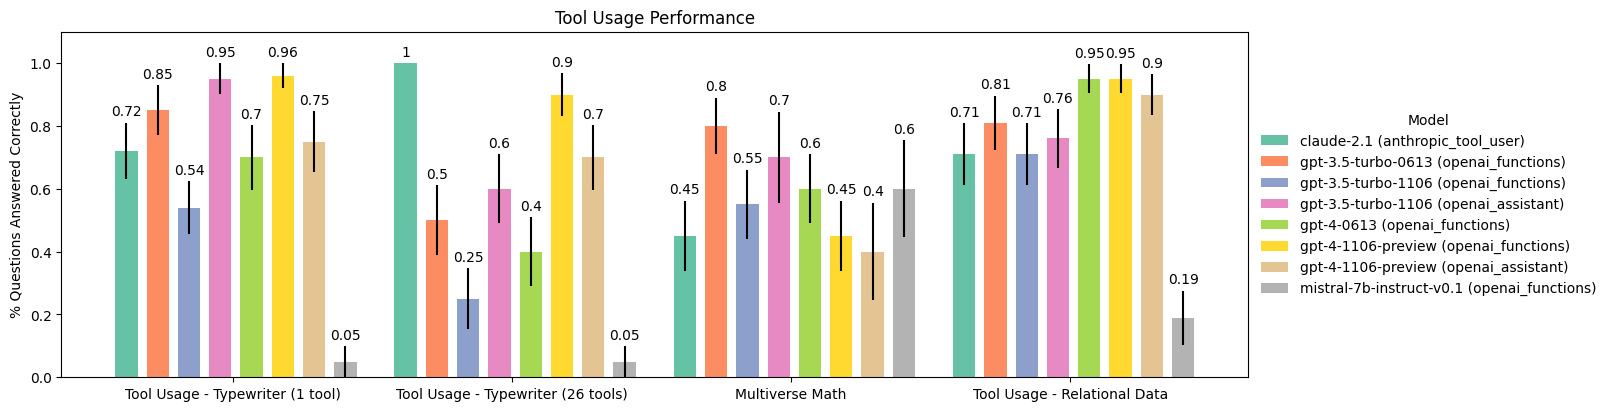

In [71]:
from itertools import product
x = np.arange(len(tasks))  # the label locations
width = 0.08  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(16, 4))
colormap = plt.get_cmap("Set2").colors
idx = 0
for model, arch  in product(models, arches):
        try:
            results = stats_df.set_index("model").loc[model]
        except:
            continue
        try:
            results = results.set_index("arch").loc[arch]
        except:
            continue
        if len(results) == 0:
            continue
        color = colormap[idx]
        idx += 1

        results = results.set_index("task").loc[tasks]
        measurement = results["% correct"]

        values = [round(m, 2) for m in measurement]

        offset = width * multiplier * 1.4
        rects = ax.bar(
            x + offset, values, width, label=f"{model} ({arch})", yerr=results["error"], color=color
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("% Questions Answered Correctly")
ax.set_title("Tool Usage Performance")
ax.set_xticks(x + width + 0.3, tasks)
ax.legend(
    loc="center left", ncols=1, bbox_to_anchor=(1.0, 0.5), frameon=False, title="Model"
)
ax.set_ylim(0, 1.10)
plt.savefig('overall_perf.png', dpi=300, bbox_inches='tight')
plt.show()